<a href="https://colab.research.google.com/github/rja868/LTSM-For-Stock-Price-Prediction/blob/main/LSTM_stock_price_forecasting_TOL_SPY_DHI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Model for Predicting the Next Day's Share Price Change from Open to Close
Richard Albanese

## Data Acquisition and Preparation

In [ ]:
! pip install tensorflow

In [ ]:
! pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00


**Library Imports**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import random
import requests

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.ticker import MultipleLocator

**Acquire Data (stock and index)**

In [ ]:
api_key = "E13TT11QUQ7OCFNA"
stock_ticker = 'TOL' # LAST TWO EARNINGS DATES MUST BE CHECKED/CORRECTED WHEN CHANGING COMPANY
hedge_1 = 'SPY'  # Used for excess return prediction and traded with opposite position to stock_ticker
index_1 = 'DHI'
start_date = '2019-12-01'  # for ATR calculation, we need data prior to 1/2/25
end_date = '2025-03-14'

def fetch_av_data(symbol, api_key):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}"
    response = requests.get(url)
    data = response.json()  # returns "data" dictionary

    time_series = data.get("Time Series (Daily)", {})  # Retrieve value for key "Time Series (Daily)" or empty dict if call fails
    df = pd.DataFrame.from_dict(time_series, orient='index')  # Convert dict to df, use the keys (dates) as the row indices

    df.index = pd.to_datetime(df.index)  # convert index (dates) to datetime objects
    df.sort_index(inplace=True)  # sort by index (chronologically)

    # Rename columns for clarity
    df.rename(columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
    }, inplace=True)

    # Convert numerical columns to float
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # converted values are reassigned back to the same columns. If values can't be converted, replace with NaN

    return df

# Fetch data for all securities
stock_data = fetch_av_data(stock_ticker, api_key)
hedge_1_data = fetch_av_data(hedge_1, api_key)
index_1_data = fetch_av_data(index_1, api_key)

# Filter data to the desired date range
stock_data = stock_data.loc[start_date:end_date]  # slice df to only include rows that fall between start_date and end_date (inclusive)
hedge_1_data = hedge_1_data.loc[start_date:end_date]
index_1_data = index_1_data.loc[start_date:end_date]

# Find the dates (index values) common to all four datasets and store in common_index
common_index = stock_data.index.intersection(hedge_1_data.index).intersection(index_1_data.index)

# Align each dataset using the common index
stock_data = stock_data.loc[common_index]
hedge_1_data = hedge_1_data.loc[common_index]
index_1_data = index_1_data.loc[common_index]

# Print shapes for verification
print("Stock shape:", stock_data.shape)
print("Hedge_1 1 shape:", hedge_1_data.shape)
print("Index 1 shape:", index_1_data.shape)


Stock shape: (1328, 5)
Hedge_1 1 shape: (1328, 5)
Index 1 shape: (1328, 5)


**Add Day of Week Features**

In [ ]:
 stock_data['Day of Week'] = stock_data.index.dayofweek  # dayofweek attribute returns an integer where Monday is 0 and Sunday is 6

# Apply cyclical encoding to represent the cyclical relationship of the days of the week, for a 5-day trading week (Monday=0, Friday=4)
# Numerical encoding (0 to 4) doesn't capture relationship because 4 and 0 are numerically far apart
# sin,cos maps the day of the week to a point on a circle so days close to each other (including Friday > Monday) will have similar sine and cosine values
stock_data['Day_Sin'] = np.sin(2 * np.pi * stock_data['Day of Week'] / 5)
stock_data['Day_Cos'] = np.cos(2 * np.pi * stock_data['Day of Week'] / 5)

**Add Earnings Dates (AlphaVantage)**

In [ ]:
# Fetches earnings dates (reportedDate) from Alpha Vantage
def fetch_EPS_dates(stock_ticker, api_key):

  # Construct the URL for the EARNINGS function.
  url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={stock_ticker}&apikey={api_key}"

  # Make the API request.
  response = requests.get(url)
  data = response.json()

  # Check the keys in the returned JSON.
  print("Returned keys:", data.keys())

  # Alpha Vantage returns two keys: 'annualEarnings' and 'quarterlyEarnings'.
  if "quarterlyEarnings" in data:  # Use 'quarterlyEarnings' which typically includes a 'reportedDate' field.
      quarterly_data = data["quarterlyEarnings"]
  else:
      raise ValueError("Alpha Vantage did not return quarterly earnings data.")

  # Extract the 'reportedDate' for each earnings report.
  earnings_info = [entry["reportedDate"] for entry in quarterly_data if entry.get("reportedDate")]

  # Convert the list of strings into a pandas DatetimeIndex and sort
  EPS_dates = pd.to_datetime(earnings_info).sort_values()

  return EPS_dates

earnings_dates = fetch_EPS_dates(stock_ticker, api_key)
print("Earnings Dates:")
print(earnings_dates)

Returned keys: dict_keys(['symbol', 'annualEarnings', 'quarterlyEarnings'])
Earnings Dates:
DatetimeIndex(['1996-02-26', '1996-05-23', '1996-08-22', '1996-12-11',
               '1997-02-26', '1997-05-21', '1997-08-26', '1997-12-09',
               '1998-02-24', '1998-05-20',
               ...
               '2022-12-06', '2023-02-21', '2023-05-23', '2023-08-22',
               '2023-12-05', '2024-02-20', '2024-05-21', '2024-08-20',
               '2024-12-09', '2025-02-18'],
              dtype='datetime64[ns]', length=117, freq=None)


**Replace Last Two Dates with the Correct Dates**

In [ ]:
# Earnings_dates is a DatetimeIndex and the last two values (from Alpha Vantage) are incorrect
# Convert to a Series to modify the values.
earnings_series = pd.Series(earnings_dates)

# Print current values to inspect:
print("Before correction:")
print(earnings_series.tail())

# Manually update the last two dates:
earnings_series.iloc[-2] = pd.to_datetime('2024-12-09')  # two quarters back
earnings_series.iloc[-1] = pd.to_datetime('2025-02-18')  # most recent (last EPS)

# Convert back to DatetimeIndex:
earnings_dates = pd.DatetimeIndex(earnings_series)

print()
print("After correction:")
print(earnings_dates)

Before correction:
112   2024-02-20
113   2024-05-21
114   2024-08-20
115   2024-12-09
116   2025-02-18
dtype: datetime64[ns]

After correction:
DatetimeIndex(['1996-02-26', '1996-05-23', '1996-08-22', '1996-12-11',
               '1997-02-26', '1997-05-21', '1997-08-26', '1997-12-09',
               '1998-02-24', '1998-05-20',
               ...
               '2022-12-06', '2023-02-21', '2023-05-23', '2023-08-22',
               '2023-12-05', '2024-02-20', '2024-05-21', '2024-08-20',
               '2024-12-09', '2025-02-18'],
              dtype='datetime64[ns]', length=117, freq=None)


**Calculate Number of Trading Days Since Last EPS**

In [ ]:
# Ensure earnings_dates are normalized (i.e., time set to midnight, no timezone)
normalized_earnings_dates = pd.to_datetime(earnings_dates).normalize()

# Initialize new column
stock_data['Days_Since_EPS'] = np.nan

# Loop over each trading day in stock_data
for current_date in stock_data.index:
    current_date_norm = current_date.normalize()  # Normalize current_date
    past_earnings = normalized_earnings_dates[normalized_earnings_dates <= current_date_norm]  # Get all earnings dates on or before the current date

    if len(past_earnings) > 0:
        last_earnings_date = past_earnings.max()  # Get maximum value (most recent date) in post_earnings
        # Get the integer positions in the stock_data index for the earnings date and current date.
        # get_indexer with method='nearest' in case the exact earnings date is not present in the index.
        start_idx = stock_data.index.get_indexer([last_earnings_date], method='nearest')[0]
        end_idx = stock_data.index.get_indexer([current_date_norm], method='nearest')[0]
        # The difference in index positions is our count of trading days between the two dates.
        trading_days = end_idx - start_idx
        stock_data.at[current_date, 'Days_Since_EPS'] = trading_days
    else:
        stock_data.at[current_date, 'Days_Since_EPS'] = None

# Convert the column to a nullable integer type
stock_data['Days_Since_EPS'] = stock_data['Days_Since_EPS'].astype('Int64')

In [ ]:
print(stock_data[['Days_Since_EPS']].tail(20))  # First 10 rows
print()
print("NaN values", stock_data[['Days_Since_EPS']].isna().sum())  # Count NaNs (should be zero)

            Days_Since_EPS
2025-02-14              45
2025-02-18               0
2025-02-19               1
2025-02-20               2
2025-02-21               3
2025-02-24               4
2025-02-25               5
2025-02-26               6
2025-02-27               7
2025-02-28               8
2025-03-03               9
2025-03-04              10
2025-03-05              11
2025-03-06              12
2025-03-07              13
2025-03-10              14
2025-03-11              15
2025-03-12              16
2025-03-13              17
2025-03-14              18

NaN values Days_Since_EPS    0
dtype: int64


**Add Price Change Open to Close**

In [ ]:
# Compute percentage change from Open to Close for current day
stock_data['Targ_Stock_Current_Day_%_Change'] = ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100

**Add Column for Next Day's Price Change (Stock and Index)**


In [ ]:
# Get next day's percentage change for stock (open to close)
stock_data['Targ_Stock_Next_Day_%_Change'] = stock_data['Targ_Stock_Current_Day_%_Change'].shift(-1)

**Add Daily Returns for Index, Excess Return for Stock and Next Day's Excess Return**

In [ ]:
# Compute index_1 and hedge_1 Open to Close % Change for the current day
index_1_data['Index_1_Daily_%_Change'] = ((index_1_data['Close'] - index_1_data['Open']) / index_1_data['Open']) * 100
hedge_1_data['hedge_1_Daily_%_Change'] = ((hedge_1_data['Close'] - hedge_1_data['Open']) / hedge_1_data['Open']) * 100

# Add to stock_data
stock_data['Index_1_Daily_%_Change'] = index_1_data['Index_1_Daily_%_Change']
stock_data['hedge_1_Daily_%_Change'] = hedge_1_data['hedge_1_Daily_%_Change']

# Compute Excess return for current day: Excess return = stock daily % change - index_1 daily % change
stock_data['Excess_Return_vs_Hedge_1'] = stock_data['Targ_Stock_Current_Day_%_Change'] - stock_data['hedge_1_Daily_%_Change']

# Shift for Next-Day Excess Return
stock_data['Next_Day_Excess_Return_vs_Hedge_1'] = stock_data['Excess_Return_vs_Hedge_1'].shift(-1)

# Confirm everything lines up properly
print(stock_data[['Targ_Stock_Current_Day_%_Change', 'Excess_Return_vs_Hedge_1', 'Next_Day_Excess_Return_vs_Hedge_1']].tail())

            Targ_Stock_Current_Day_%_Change  Excess_Return_vs_Hedge_1  \
2025-03-10                        -1.837560                 -0.602513   
2025-03-11                        -0.121541                  0.500554   
2025-03-12                        -1.895647                 -1.308636   
2025-03-13                        -2.884615                 -1.618702   
2025-03-14                         0.913989                 -0.290809   

            Next_Day_Excess_Return_vs_Hedge_1  
2025-03-10                           0.500554  
2025-03-11                          -1.308636  
2025-03-12                          -1.618702  
2025-03-13                          -0.290809  
2025-03-14                                NaN  


**Daily Range for Stock**

In [ ]:
# For target stock, compute current day's price range as %
stock_data['Targ_Stock_Daily_Range_%'] = ((stock_data['High'] - stock_data['Low']) / stock_data['Low']) * 100

**Daily Range for Index 1 and Hedge_1**

In [ ]:
# Merge High and Low prices into stock_data
# Select and rename the relevant columns in spy_data
index_1_data_subset = index_1_data[['High', 'Low']].rename(columns={'High': 'Index_1_High', 'Low': 'Index_1_Low'})
hedge_1_data_subset = hedge_1_data[['High', 'Low']].rename(columns={'High': 'hedge_1_High', 'Low': 'hedge_1_Low'})

# Merge on the index
stock_data = stock_data.merge(index_1_data_subset, left_index=True, right_index=True, how='left')
stock_data = stock_data.merge(hedge_1_data_subset, left_index=True, right_index=True, how='left')

# Verify that the new columns are added
print(stock_data.head())

# Calculate Daily Ranges in % terms
stock_data['Index_1_Daily_Range_%'] = ((index_1_data_subset['Index_1_High'] - index_1_data_subset['Index_1_Low']) / index_1_data_subset['Index_1_Low']) * 100
stock_data['hedge_1_Daily_Range_%'] = ((hedge_1_data_subset['hedge_1_High'] - hedge_1_data_subset['hedge_1_Low']) / hedge_1_data_subset['hedge_1_Low']) * 100

             Open   High    Low  Close   Volume  Day of Week   Day_Sin  \
2019-12-02  40.14  40.22  39.40  39.73  1095612            0  0.000000   
2019-12-03  39.52  40.02  39.35  39.83  2036727            1  0.951057   
2019-12-04  39.95  40.27  39.49  40.11  1613320            2  0.587785   
2019-12-05  39.97  40.94  39.97  40.91  1777464            3 -0.587785   
2019-12-06  40.92  41.45  40.72  40.88  2506700            4 -0.951057   

             Day_Cos  Days_Since_EPS  Targ_Stock_Current_Day_%_Change  \
2019-12-02  1.000000               0                        -1.021425   
2019-12-03  0.309017               1                         0.784413   
2019-12-04 -0.809017               2                         0.400501   
2019-12-05 -0.809017               3                         2.351764   
2019-12-06  0.309017               4                        -0.097752   

            Targ_Stock_Next_Day_%_Change  Index_1_Daily_%_Change  \
2019-12-02                      0.784413        

**Relative Volatility Feature**

In [ ]:
# Compute metric for comparing trading ranges
stock_data['Targ_to_Hedge_1_Daily_Range_Ratio'] = stock_data['Targ_Stock_Daily_Range_%'] / stock_data['hedge_1_Daily_Range_%']

**Add ATR**

In [ ]:
stock_data['Targ_Stock_Prev_Close'] = stock_data['Close'].shift(1)  # Get previous day's close

# Function to compute the True Range (TR)
def compute_tr(row):
    # If Prev_Close is NA (first row), just use the current day's opening price.
    if pd.isna(row['Targ_Stock_Prev_Close']):
        return row['Open']
    else:
        diff1 = row['High'] - row['Low']  # Current day's range
        diff2 = abs(row['High'] - row['Targ_Stock_Prev_Close'])  # Current day's high - previous close
        diff3 = abs(row['Low'] - row['Targ_Stock_Prev_Close'])  # Current day's low - previous close
        return max(diff1, diff2, diff3)

# Apply the function row-wise
stock_data['TR'] = stock_data.apply(compute_tr, axis=1)

# Now compute the 14-day Average True Range (ATR), 14 days in the most common
stock_data['Targ_Stock_ATR'] = stock_data['TR'].rolling(window=14).mean()

# Optionally drop the intermediate columns
stock_data.drop(['Targ_Stock_Prev_Close', 'TR'], axis=1, inplace=True)

print(stock_data[['Targ_Stock_ATR']].head(20))


            Targ_Stock_ATR
2019-12-02             NaN
2019-12-03             NaN
2019-12-04             NaN
2019-12-05             NaN
2019-12-06             NaN
2019-12-09             NaN
2019-12-10             NaN
2019-12-11             NaN
2019-12-12             NaN
2019-12-13             NaN
2019-12-16             NaN
2019-12-17             NaN
2019-12-18             NaN
2019-12-19        3.765714
2019-12-20        0.975000
2019-12-23        0.987143
2019-12-24        0.972857
2019-12-26        0.937143
2019-12-27        0.932143
2019-12-30        0.921429


**Add Rolling Correlation and Plot**

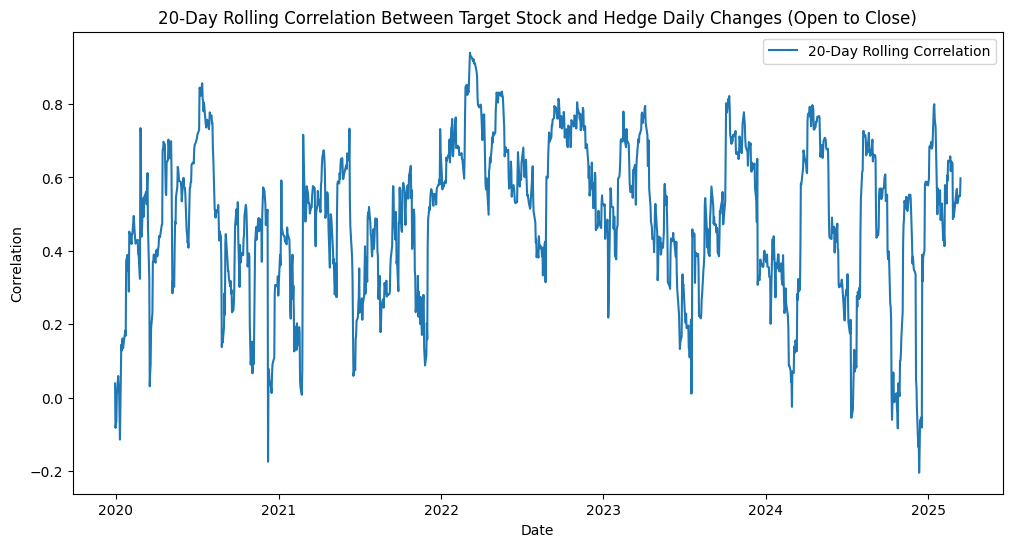

In [ ]:
# Calculate the 20-day rolling correlation between target stock and hedge daily changes.
stock_data['Rolling_Corr_20'] = stock_data['Targ_Stock_Current_Day_%_Change'].rolling(window=20).corr(stock_data['hedge_1_Daily_%_Change'])

# Determine the first valid date (after the initial NaNs due to the rolling window)
start_date_corr = stock_data['Rolling_Corr_20'].first_valid_index()

# Plot rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Rolling_Corr_20'], label='20-Day Rolling Correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('20-Day Rolling Correlation Between Target Stock and Hedge Daily Changes (Open to Close)')

plt.legend()
plt.grid(False)
plt.show()

**Add Volume Features**

In [ ]:
stock_data['Rel_Volume'] = stock_data['Volume'] / stock_data['Volume'].rolling(window=20).mean()  # Relative volume (compares current day's vol to moving avg)
stock_data['Volume_MA_10'] = stock_data['Volume'].rolling(window=10).mean()  # Short-term moving average
stock_data['Volume_MA_50'] = stock_data['Volume'].rolling(window=50).mean()  # Long-term moving average

**Print Data (Unscaled)**

In [ ]:
# Print data
# Set pandas to display all columns
pd.set_option('display.max_columns', None)  # No limit on the number of columns
pd.set_option('display.width', 1000)  # Set display width to a large value
print(stock_data.head(20))

             Open   High    Low  Close   Volume  Day of Week   Day_Sin   Day_Cos  Days_Since_EPS  Targ_Stock_Current_Day_%_Change  Targ_Stock_Next_Day_%_Change  Index_1_Daily_%_Change  hedge_1_Daily_%_Change  Excess_Return_vs_Hedge_1  Next_Day_Excess_Return_vs_Hedge_1  Targ_Stock_Daily_Range_%  Index_1_High  Index_1_Low  hedge_1_High  hedge_1_Low  Index_1_Daily_Range_%  hedge_1_Daily_Range_%  Targ_to_Hedge_1_Daily_Range_Ratio  Targ_Stock_ATR  Rolling_Corr_20  Rel_Volume  Volume_MA_10  Volume_MA_50
2019-12-02  40.14  40.22  39.40  39.73  1095612            0  0.000000  1.000000               0                        -1.021425                      0.784413               -0.777858               -0.937728                 -0.083697                           0.492821                  2.081218         55.34        54.33        314.66       311.17               1.859010               1.121573                           1.855624             NaN              NaN         NaN           NaN         

**Prior to Splitting, Drop NaNs and Remove Dates Prior to 2020-01-02**

In [ ]:
stock_data.dropna(inplace=True)
stock_data = stock_data.loc['2020-01-02':]

**Split Data (Train/Val/Test)**

In [ ]:
print(len(stock_data))

1278


In [ ]:
N = len(stock_data)  # total rows
days_in_test = 90  # Only test for 90 days because of model degradation

train_end = N - (2*days_in_test)
val_end = N - days_in_test

df_train = stock_data.iloc[:train_end].copy()
df_val   = stock_data.iloc[train_end:val_end].copy()
df_test  = stock_data.iloc[val_end:].copy()

print("Train:", df_train.shape)
print("Val:  ", df_val.shape)
print("Test: ", df_test.shape)

Train: (1098, 28)
Val:   (90, 28)
Test:  (90, 28)


In [ ]:
print(test_ratio)

0.15


**Scaling**

# **LTSM Model Building**

**Create LSTM Sequences**

In [ ]:
# Initialize Scalers
eps_scaler = StandardScaler()
volume_scaler = StandardScaler()
targ_stock_next_day_change_scaler = StandardScaler()
excess_scaler = StandardScaler()

change_scaler_targ_stock = StandardScaler()
change_scaler_index_1 = StandardScaler()
change_scaler_hedge_1 = StandardScaler()

range_scaler_targ_stock = StandardScaler()
range_scaler_index_1 = StandardScaler()
range_scaler_hedge_1 = StandardScaler()

range_scaler_ratio = StandardScaler()
ATR_scaler = RobustScaler()  # Robust scaler reduces impact of extreme ATR values (periods of high volality)
corr_scaler = StandardScaler()
relative_vol_scaler = StandardScaler()
vol_short_term_moving_avg_scaler = StandardScaler()
vol_long_term_moving_avg_scaler = StandardScaler()


# Fit on train only
df_train['Scaled_Targ_Stock_Current_Day_%_Change'] = change_scaler_targ_stock.fit_transform(df_train[['Targ_Stock_Current_Day_%_Change']])
df_train['Scaled_Volume'] = volume_scaler.fit_transform(df_train[['Volume']])
df_train['Scaled_Days_Since_EPS'] = eps_scaler.fit_transform(df_train[['Days_Since_EPS']])
df_train['Scaled_Targ_Stock_Next_Day_%_Change'] = targ_stock_next_day_change_scaler.fit_transform(df_train[['Targ_Stock_Next_Day_%_Change']])
df_train['Scaled_Next_Day_Excess_Return_vs_Hedge_1'] = excess_scaler.fit_transform(df_train[['Next_Day_Excess_Return_vs_Hedge_1']])

df_train['Scaled_Index_1_%_Change'] = change_scaler_index_1.fit_transform(df_train[['Index_1_Daily_%_Change']])
df_train['Scaled_hedge_1_%_Change'] = change_scaler_hedge_1.fit_transform(df_train[['hedge_1_Daily_%_Change']])

df_train['Scaled_Targ_Stock_Daily_Range_%'] = range_scaler_targ_stock.fit_transform(df_train[['Targ_Stock_Daily_Range_%']])
df_train['Scaled_Index_1_Daily_Range_%'] = range_scaler_index_1.fit_transform(df_train[['Index_1_Daily_Range_%']])
df_train['Scaled_hedge_1_Daily_Range_%'] = range_scaler_hedge_1.fit_transform(df_train[['hedge_1_Daily_Range_%']])

df_train['Targ_to_Hedge_1_Scaled_Daily_Range_Ratio'] = range_scaler_ratio.fit_transform(df_train[['Targ_to_Hedge_1_Daily_Range_Ratio']])
df_train['Scaled_Targ_Stock_ATR'] = ATR_scaler.fit_transform(df_train[['Targ_Stock_ATR']])
df_train['Scaled_Rolling_Corr_20'] = corr_scaler.fit_transform(df_train[['Rolling_Corr_20']])
df_train['Scaled_Rel_Volume'] = relative_vol_scaler.fit_transform(df_train[['Rel_Volume']])
df_train['Scaled_Volume_MA_10'] = vol_short_term_moving_avg_scaler.fit_transform(df_train[['Volume_MA_10']])
df_train['Scaled_Volume_MA_50'] = vol_long_term_moving_avg_scaler.fit_transform(df_train[['Volume_MA_50']])

# Then transform val and test (don't fit again, only transform)
# Val data
df_val['Scaled_Targ_Stock_Current_Day_%_Change'] = change_scaler_targ_stock.transform(df_val[['Targ_Stock_Current_Day_%_Change']])
df_val['Scaled_Volume'] = volume_scaler.transform(df_val[['Volume']])
df_val['Scaled_Days_Since_EPS'] = eps_scaler.transform(df_val[['Days_Since_EPS']])
df_val['Scaled_Targ_Stock_Next_Day_%_Change'] = targ_stock_next_day_change_scaler.transform(df_val[['Targ_Stock_Next_Day_%_Change']])
df_val['Scaled_Next_Day_Excess_Return_vs_Hedge_1'] = excess_scaler.transform(df_val[['Next_Day_Excess_Return_vs_Hedge_1']])

df_val['Scaled_Index_1_%_Change'] = change_scaler_index_1.transform(df_val[['Index_1_Daily_%_Change']])
df_val['Scaled_hedge_1_%_Change'] = change_scaler_hedge_1.transform(df_val[['hedge_1_Daily_%_Change']])

df_val['Scaled_Targ_Stock_Daily_Range_%'] = range_scaler_targ_stock.transform(df_val[['Targ_Stock_Daily_Range_%']])
df_val['Scaled_Index_1_Daily_Range_%'] = range_scaler_index_1.transform(df_val[['Index_1_Daily_Range_%']])
df_val['Scaled_hedge_1_Daily_Range_%'] = range_scaler_hedge_1.transform(df_val[['hedge_1_Daily_Range_%']])

df_val['Targ_to_Hedge_1_Scaled_Daily_Range_Ratio'] = range_scaler_ratio.transform(df_val[['Targ_to_Hedge_1_Daily_Range_Ratio']])
df_val['Scaled_Targ_Stock_ATR'] = ATR_scaler.transform(df_val[['Targ_Stock_ATR']])
df_val['Scaled_Rolling_Corr_20'] = corr_scaler.transform(df_val[['Rolling_Corr_20']])
df_val['Scaled_Rel_Volume'] = relative_vol_scaler.transform(df_val[['Rel_Volume']])
df_val['Scaled_Volume_MA_10'] = vol_short_term_moving_avg_scaler.transform(df_val[['Volume_MA_10']])
df_val['Scaled_Volume_MA_50'] = vol_long_term_moving_avg_scaler.transform(df_val[['Volume_MA_50']])


# Test data
df_test['Scaled_Targ_Stock_Current_Day_%_Change'] = change_scaler_targ_stock.transform(df_test[['Targ_Stock_Current_Day_%_Change']])
df_test['Scaled_Volume'] = volume_scaler.transform(df_test[['Volume']])
df_test['Scaled_Days_Since_EPS'] = eps_scaler.transform(df_test[['Days_Since_EPS']])
df_test['Scaled_Targ_Stock_Next_Day_%_Change'] = targ_stock_next_day_change_scaler.transform(df_test[['Targ_Stock_Next_Day_%_Change']])
df_test['Scaled_Next_Day_Excess_Return_vs_Hedge_1'] = excess_scaler.transform(df_test[['Next_Day_Excess_Return_vs_Hedge_1']])

df_test['Scaled_Index_1_%_Change'] = change_scaler_index_1.transform(df_test[['Index_1_Daily_%_Change']])
df_test['Scaled_hedge_1_%_Change'] = change_scaler_hedge_1.transform(df_test[['hedge_1_Daily_%_Change']])

df_test['Scaled_Targ_Stock_Daily_Range_%'] = range_scaler_targ_stock.transform(df_test[['Targ_Stock_Daily_Range_%']])
df_test['Scaled_Index_1_Daily_Range_%'] = range_scaler_index_1.transform(df_test[['Index_1_Daily_Range_%']])
df_test['Scaled_hedge_1_Daily_Range_%']  = range_scaler_hedge_1.transform(df_test[['hedge_1_Daily_Range_%']])

df_test['Targ_to_Hedge_1_Scaled_Daily_Range_Ratio'] = range_scaler_ratio.transform(df_test[['Targ_to_Hedge_1_Daily_Range_Ratio']])
df_test['Scaled_Targ_Stock_ATR']  = ATR_scaler.transform(df_test[['Targ_Stock_ATR']])
df_test['Scaled_Rolling_Corr_20'] = corr_scaler.transform(df_test[['Rolling_Corr_20']])
df_test['Scaled_Rel_Volume'] = relative_vol_scaler.transform(df_test[['Rel_Volume']])
df_test['Scaled_Volume_MA_10'] = vol_short_term_moving_avg_scaler.transform(df_test[['Volume_MA_10']])
df_test['Scaled_Volume_MA_50'] = vol_long_term_moving_avg_scaler.transform(df_test[['Volume_MA_50']])

In [ ]:
# Define sequence length (how many past days the model will use)
sequence_length = 20

def create_lstm_sequences(df, sequence_length, feature_cols, target_col):
    X_list, y_list = [], []
    values = df[feature_cols].values  # shape (n_rows, n_features)
    target = df[target_col].values    # shape (n_rows,)

    for i in range(len(df) - sequence_length):
        X_list.append(values[i : i + sequence_length])
        y_list.append(target[i + sequence_length])

    return np.array(X_list), np.array(y_list)

# Select input features and target
features_scaled = [
    'Scaled_Targ_Stock_Current_Day_%_Change',  # Target stock % change from open to close
    'Scaled_Volume',  # Shares traded for the current day
    'Scaled_Days_Since_EPS',  # Days since the last EPS release
    'Scaled_Index_1_%_Change',  # % change for a different security
    'Scaled_hedge_1_%_Change',  # % change for the security used for hedging the trade
    'Scaled_Targ_Stock_Daily_Range_%',  # daily range for target stock
    'Scaled_Index_1_Daily_Range_%',  # daily range for different security
    'Scaled_hedge_1_Daily_Range_%',  # daily range for the security used for hedging
    'Targ_to_Hedge_1_Scaled_Daily_Range_Ratio',  # ratio of daily range for target stock to daily range for hedge
    'Scaled_Targ_Stock_ATR',  # ATR for target stock
    'Day_Sin',  # day of week
    'Day_Cos',  # day of week
    'Scaled_Rolling_Corr_20',  # 20-day rolling correlation between target stock and hedge daily changes
    'Scaled_Rel_Volume',  # relative volume
    'Scaled_Volume_MA_10',  # short-term moving average of volume
    'Scaled_Volume_MA_50',  # long-term moving average of volume
    ]

target = 'Scaled_Next_Day_Excess_Return_vs_Hedge_1'  # Target is the next day's excess return % (target stock return - hedge return)

X_train, y_train = create_lstm_sequences(df_train, sequence_length, features_scaled, target)
X_val,   y_val   = create_lstm_sequences(df_val,   sequence_length, features_scaled, target)
X_test,  y_test  = create_lstm_sequences(df_test,  sequence_length, features_scaled, target)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:",   y_val.shape)
print("X_test: ", X_test.shape,  "y_test:",  y_test.shape)

X_train: (1078, 20, 16) y_train: (1078,)
X_val:   (70, 20, 16) y_val: (70,)
X_test:  (70, 20, 16) y_test: (70,)


**Correlation Matrix for Features**

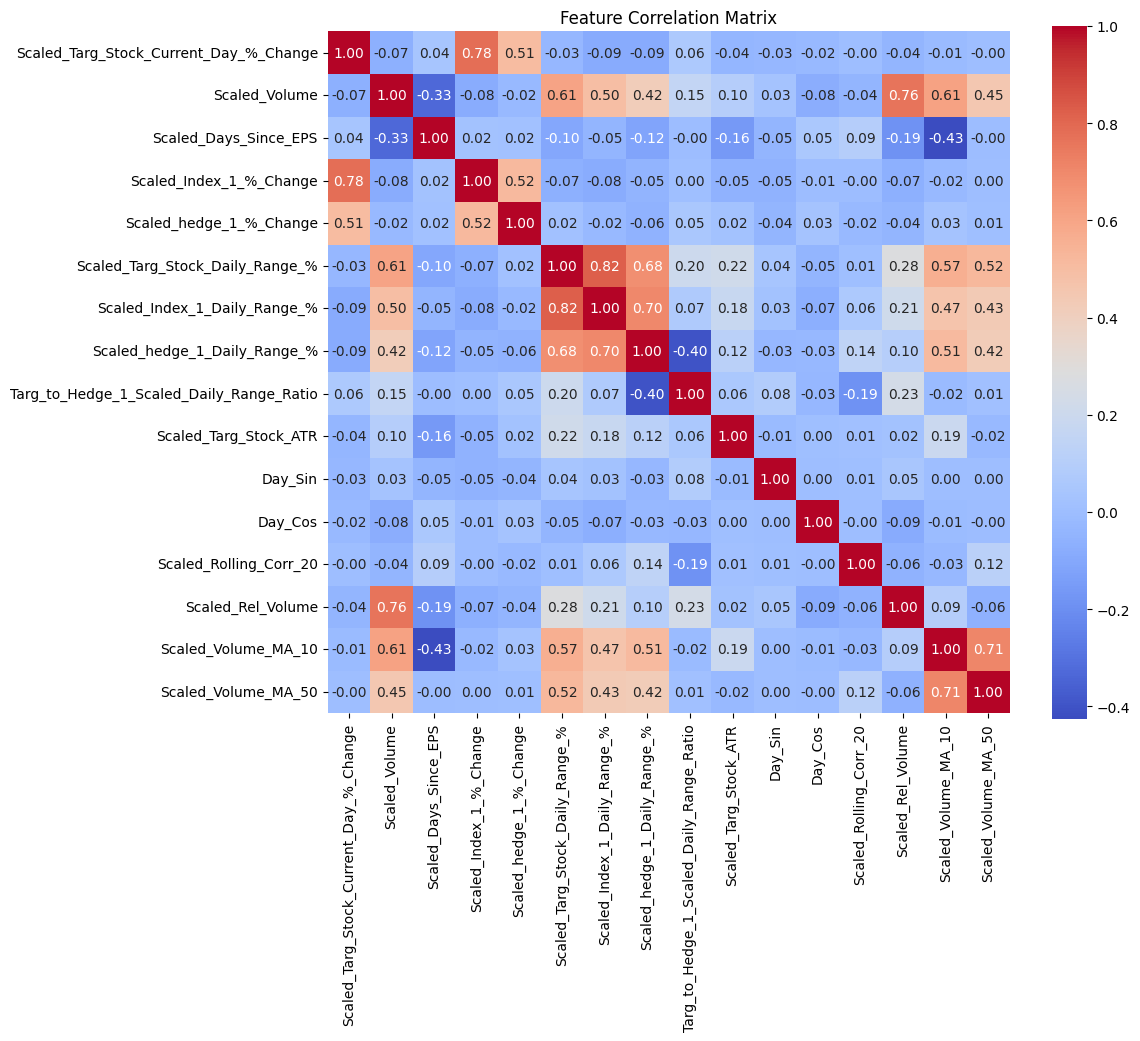

In [ ]:
# Compute the correlation matrix for the selected features in the training set.
corr_matrix = df_train[features_scaled].corr()

# Plot a heatmap of the correlation matrix.
plt.figure(figsize=(11, 9))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

# **Model:  Keras Tuned LSTM Model**

**KerasTuner Function for Model Building**

In [ ]:
def build_lstm_model(hp):
    # Determine number of input features (should match features list length)
    num_features = X_train.shape[2]

    # Create a binary mask for feature selection.
    feature_mask = []
    for i in range(num_features):
        flag = hp.Choice(f'use_feature_{i}', values=[0, 1])  # Tuner decides whether to use each feature (0 = exclude, 1 = include)
        feature_mask.append(flag)
    feature_mask_tensor = tf.constant(feature_mask, dtype=tf.float32, shape=[num_features])
  # Convert the mask list to a TensorFlow constant.

    model = Sequential()
    # First layer: Apply the feature mask to the input
    model.add(Lambda(lambda x: x * feature_mask_tensor, input_shape=(X_train.shape[1], num_features)))  # Multiply input layer by feature mask (0 or 1)

    # 1st LSTM layer
    # hp.Int method defines a tunable integer hyperparameter named 'units_1', the quantity of LSTM neurons can vary between 80 and 120
    units_1 = hp.Int('units_1', min_value=80, max_value=120, step=5)  # increments of 5 are considered
    model.add(LSTM(units_1, return_sequences=True))  # the layer outputs the hidden state for every time step (not just final state)
    # dropout layer helps prevent overfitting by randomly setting a fraction of the layer's input to zero during training
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # 2nd LSTM layer
    units_2 = hp.Int('units_2', min_value=35, max_value=65, step=5)
    model.add(LSTM(units_2, return_sequences=True))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    # 3rd LSTM layer
    units_3 = hp.Int('units_3', min_value=35, max_value=65, step=5)
    model.add(LSTM(units_3, return_sequences=False))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1)))

    # Output layer
    # only one output (prediction for next day's excess return) is needed, "linear" doesn't contrain the output into a specific range
    model.add(Dense(1, activation='linear'))

    # Learning rate hyperparameter
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5])  # candidate learning rates the tuner will explore
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  # Adam is popular, adapts learning rate to each parameter

    # Compile the model using MAE as the loss function
    model.compile(optimizer=optimizer, loss='mae')  # MAE is often used for regression problems because its less sensitive to outlier comparied to MSE
    return model


**Instantiate the Tuner**

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=build_lstm_model,  # tell the tuner to use the function build_lstm_model to build a new model for each trial
    objective='val_loss',  # optimize model to minimize validation loss, models are compared based on their performance on the val set
    max_trials=10,         # how many random hyperparameter combos to try, increasing allows tuner to explore a wider range of hyperparam settings
    overwrite=True,        # if you want to overwrite old results
    directory='lstm_tuning',  # where to save results and logs
    project_name='my_lstm_project'  # project name
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Run the Search**

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # if val loss stops improving, process may stop early
    patience=10,  # if the val loss doesn't improve for 10 consecutive epochs, training will stop
    restore_best_weights=True  # model weights are reverted to the values corresponding to the epoch with the lowest val loss
)

tuner.search(
    X_train, y_train,  # training inputs and target
    validation_data=(X_val, y_val),  # val data
    epochs=50,  # number per trial
    batch_size=32,     # batch_size can also be tuned
    shuffle=False,     # crucial for time-series
    callbacks=[early_stopping],
    verbose=1  # show progress updates
)

Trial 10 Complete [00h 00m 14s]
val_loss: 0.5172892212867737

Best val_loss So Far: 0.5130970478057861
Total elapsed time: 00h 02m 11s


**Retrieve the Best Model & Hyperparameters**

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]  # retrieve best hyperparameters
print("Best hyperparameters:", best_hp.values)

model = tuner.hypermodel.build(best_hp)  # returns a model with best hyperparameters

# Print model summary
model.summary()

Best hyperparameters: {'use_feature_0': 0, 'use_feature_1': 0, 'use_feature_2': 1, 'use_feature_3': 0, 'use_feature_4': 1, 'use_feature_5': 1, 'use_feature_6': 1, 'use_feature_7': 0, 'use_feature_8': 1, 'use_feature_9': 1, 'use_feature_10': 0, 'use_feature_11': 1, 'use_feature_12': 1, 'use_feature_13': 0, 'use_feature_14': 1, 'use_feature_15': 0, 'units_1': 95, 'dropout_1': 0.2, 'units_2': 45, 'dropout_2': 0.1, 'units_3': 60, 'dropout_3': 0.4, 'learning_rate': 1e-05}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 20, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 20, 95)              │          42,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 95)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 20, 45)              │          25,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 45)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 60)                  │          25,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,441 (365.00 KB)

 Trainable params: 93,441 (365.00 KB)

 Non-trainable params: 0 (0.00 B)

**Train Tuned LSTM Model**

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # max number of epochs to train the model (might stop early)
    batch_size=32,  # model will process 32 samples at a time before updating the weights (important for memory mgmt and training dynamics)
    shuffle=False,  # data is fed in chronologically
    callbacks=[early_stopping]
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.9395 - val_loss: 0.5364
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9384 - val_loss: 0.5335
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9374 - val_loss: 0.5313
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9377 - val_loss: 0.5292
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9390 - val_loss: 0.5282
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9417 - val_loss: 0.5271
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9405 - val_loss: 0.5264
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9374 - val_loss: 0.5257
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9398 - val_loss: 0.5250
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9359 - val_loss: 0.5246
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9387 - val_loss: 0.5244
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

**Generate Predictions on Test Set**

In [ ]:
# Generate scaled predictions (scaled).
y_pred_scaled_tuned = model.predict(X_test).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


**Inverse Transform Predictions and Actual Value**

In [ ]:
# Inverse-transform the predictions and the actual y_test so they are in real % terms
y_pred_unscaled = excess_scaler.inverse_transform(y_pred_scaled_tuned.reshape(-1,1)).flatten()
y_test_unscaled = excess_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

**KDE Plot of Predictions**

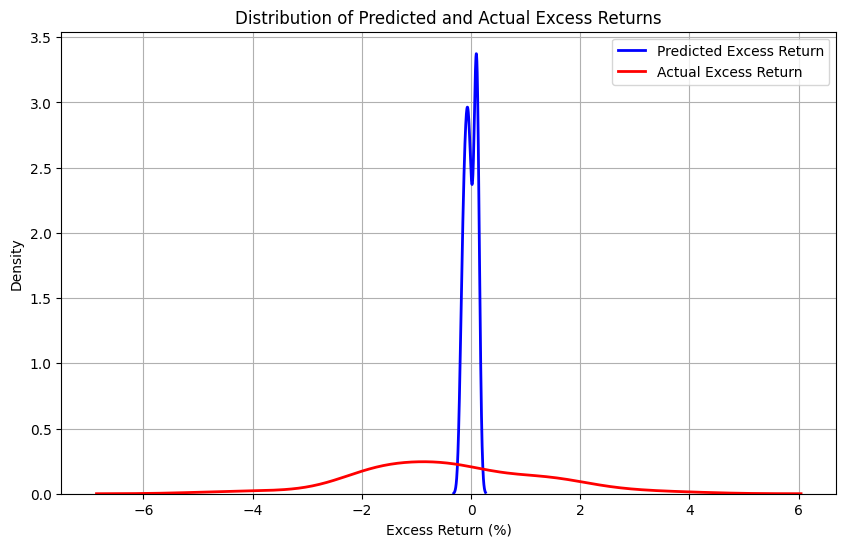

count    70.000000
mean     -0.007180
std       0.101423
min      -0.185976
25%      -0.095448
50%      -0.013462
75%       0.091701
max       0.133970
dtype: float64


In [ ]:
plt.figure(figsize=(10, 6))

# Plot the density of the tuned predictions in blue
sns.kdeplot(y_pred_unscaled, fill=False, color='blue', linewidth=2, label='Predicted Excess Return')

# Plot the density of the actual excess returns in red
sns.kdeplot(y_test_unscaled, fill=False, color='red', linewidth=2, label='Actual Excess Return')

plt.xlabel("Excess Return (%)")
plt.ylabel("Density")
plt.title("Distribution of Predicted and Actual Excess Returns")
plt.legend()
plt.grid(True)
plt.show()

import pandas as pd

# Convert y_pred_unscaled (a NumPy array) into a pandas Series.
predictions_series = pd.Series(y_pred_unscaled)

# Use the describe() method to get summary statistics.
summary_stats = predictions_series.describe()
print(summary_stats)


**Minimum Validation Loss and Mean Absolute Error**

In [ ]:
min_val_loss = min(history.history['val_loss'])
print(f"Minimum validation loss: {min_val_loss}")

absolute_errors = np.abs(y_pred_unscaled - y_test_unscaled)
mean_absolute_error = np.mean(absolute_errors)
print(f"Mean Absolute Error: {mean_absolute_error:.3f}%")

Minimum validation loss: 0.5178461074829102
Mean Absolute Error: 1.347%


**Baseline Performance (Including 1st and 2nd Half Split) Using Simple Historical Average**

In [ ]:
# Compute the historical mean from the training data.
historical_avg = df_train['Next_Day_Excess_Return_vs_Hedge_1'].mean()
print(f"{stock_ticker} vs {hedge_1}: Historical average excess return: {historical_avg:.3f}%")

# Use the mean as the constant prediction on the test set
df_test['Historical_Prediction'] = historical_avg

# Calculate the absolute error for each test sample
df_test['Absolute_Error'] = np.abs(df_test['Next_Day_Excess_Return_vs_Hedge_1'] - df_test['Historical_Prediction'])

# Compute overall Mean Absolute Error (MAE)
mae_historical = df_test['Absolute_Error'].mean()
print(f"Historical Average MAE (Baseline): {mae_historical:.3f}%")

# Split the Test Set into First and Second Halves
mid_point = len(df_test) // 2
first_half = df_test.iloc[:mid_point]
second_half = df_test.iloc[mid_point:]

# Compute the MAE for the first half and the second half.
mae_historical_first = first_half['Absolute_Error'].mean()
mae_historical_second = second_half['Absolute_Error'].mean()

print(f"Historical Average MAE (Baseline) - First half: {mae_historical_first:.3f}%")
print(f"Historical Average MAE (Baseline) - Second half: {mae_historical_second:.3f}%")


TOL vs SPY: Historical average excess return: 0.024%
Historical Average MAE (Baseline): 1.387%
Historical Average MAE (Baseline) - First half: 1.322%
Historical Average MAE (Baseline) - Second half: 1.452%


**Set Transaction Cost and Initial Capital**

In [ ]:
transaction_cost = 0.01
initial_capital = 10000

**Slice Dataset by Sequence Length**

In [ ]:
# Slice df_test by the number of days in sequence length (these rows don't have enough preceding data)
df_test_for_pnl = df_test.iloc[sequence_length:].copy()

**Performance Functions**

In [ ]:
# Capital Curve
def calculate_capital_curve(df, initial_capital):
    cap_curve = [initial_capital]
    for ret_pct in df['Daily_Return_%']:
        cap_curve.append(cap_curve[-1] * (1 + ret_pct/100.0))  # Last element in the list * multiplier, then append
    df['Capital'] = cap_curve[1:]  # align by skipping the initial value
    final_cap = df['Capital'].iloc[-1]

# Final P&L in dollars
def calculate_final_pnl(df, initial_capital):
    final_cap = df['Capital'].dropna().iloc[-1]  # Retrieve last non-null value
    final_pnl = final_cap - initial_capital
    test_days = df.shape[0]
    print(f"Final P&L (in dollars, for {test_days} trading days): ${final_pnl:,.2f}")

# Average Daily Return and Annualized Return
def calculate_perf(df):
    df['Daily_Return_Decimal'] = df['Daily_Return_%'] / 100.0  # convert return to a decimal
    avg_daily_return_decimal = df['Daily_Return_Decimal'].mean()  # Calculate the average daily return in decimal form
    annualized_return_decimal = avg_daily_return_decimal * 252.0  # Multiply by 252 to approximate annual return (no compounding)
    annualized_return_percent = annualized_return_decimal * 100  # Convert back to a percentage
    print(f"Average Daily Return: {avg_daily_return_decimal * 100:.3f}%")
    print(f"Annualized Return (simple): {annualized_return_percent:.2f}%")

# Sharpe Ratio
def calculate_sharpe_ratio(df):
    risk_free_rate_daily = 0.0  # Assume a risk-free rate; if not provided, 0 is often used
    excess_daily_returns = df['Daily_Return_Decimal'] - risk_free_rate_daily  # Compute the excess daily returns
    mean_daily_return = excess_daily_returns.mean()  # Compute the mean and standard deviation of the daily excess returns
    std_daily_return = excess_daily_returns.std()
    annualized_sharpe_ratio = np.sqrt(252) * (mean_daily_return / std_daily_return)  # The annualized Sharpe ratio = (mean daily excess return / std daily return) * sqrt(252)
    print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.2f}")

# Plot
def plot_curve(df, initial_capital):
  plt.figure(figsize=(10, 6))
  plt.plot(df['Capital'], label='Equity Curve (in $)')
  plt.title("Test Set Equity Curve: " + stock_ticker + " Hedged with " + hedge_1)
  plt.xlabel("Days in Test Set")
  plt.ylabel("Account Value (USD)")
  plt.legend()
  plt.show()


**Trading Strategy #1: Calculate P&L Using a Hedged Position: 50% L/S Stock, 50% L/S Index**

2024-11-29    10000.000000
2024-12-02     9979.230948
2024-12-03     9893.494337
2024-12-04     9703.541145
2024-12-05     9626.120045
                  ...     
2025-03-07     9724.692810
2025-03-10     9753.016625
2025-03-11     9727.631749
2025-03-12     9790.308647
2025-03-13     9868.567574
Name: Capital, Length: 70, dtype: float64
Final P&L (in dollars, for 70 trading days): $-131.43
Average Daily Return: -0.015%
Annualized Return (simple): -3.90%
Annualized Sharpe Ratio: -0.29


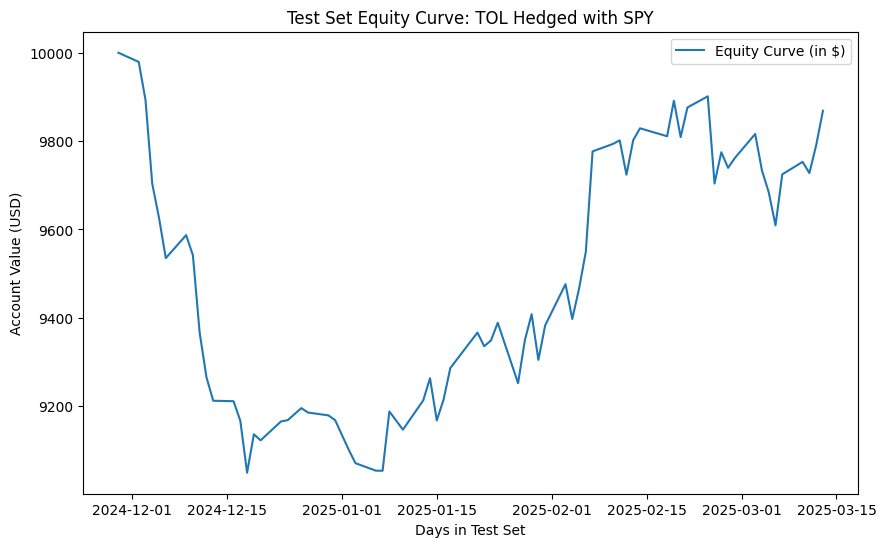

In [ ]:
# Assign Predictions
df_test_for_pnl['Predicted_Excess'] = y_pred_unscaled

# Add Required Columns
df_test_for_pnl['Stock_Change_Shifted'] = df_test_for_pnl['Targ_Stock_Current_Day_%_Change'].shift(-1)  # shift for t+1 (next day)
df_test_for_pnl['hedge_1_Change_Shifted'] = df_test_for_pnl['hedge_1_Daily_%_Change'].shift(-1)  # shift for t+1 (next day)

daily_returns = []
for i in range(len(df_test_for_pnl)):
    pred = df_test_for_pnl['Predicted_Excess'].iloc[i]

    # Only compute the trade return if tomorrow's price change exists (to avoid NaN at the end)
    if pd.notnull(df_test_for_pnl['Stock_Change_Shifted'].iloc[i]) and pd.notnull(df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i]):
        if pred > 0:
            # Trade: Long stock, short hedge.
            dr = 0.5 * (df_test_for_pnl['Stock_Change_Shifted'].iloc[i] - df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i])
        elif pred < 0:
            # Trade: Long hedge, short stock.
            dr = 0.5 * (df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i] - df_test_for_pnl['Stock_Change_Shifted'].iloc[i])
        else:
            dr = 0.0

        # Apply transaction cost only if a trade is executed
        if dr != 0:
            dr = dr - transaction_cost
    else:
        dr = 0.0

    daily_returns.append(dr)

df_test_for_pnl['Daily_Return_%'] = daily_returns

# Shift so return % is in the same row as the day the trade is executed and fill the resulting NaN with 0
df_test_for_pnl['Daily_Return_%'] = df_test_for_pnl['Daily_Return_%'].shift(1).fillna(0)


# Performance Metrics

# Capital Curve
calculate_capital_curve(df_test_for_pnl, initial_capital)

# Final P&L in dollars
calculate_final_pnl(df_test_for_pnl, initial_capital)

# Average Daily and Annualized Returns
calculate_perf(df_test_for_pnl)

# Sharpe Ratio
calculate_sharpe_ratio(df_test_for_pnl)

# Plot
plot_curve(df_test_for_pnl, initial_capital)


**Trading Strategy #2: Dynamic Position Sizing**

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean prediction for training period: 0.017566272988915443
Standard deviation of predictions for training period: 0.05424731969833374
2024-11-29    9959.461896
2024-12-02    9789.324312
2024-12-03    9414.396949
2024-12-04    9265.110145
2024-12-05    9090.877884
                 ...     
2025-03-07    9395.141472
2025-03-10    9347.174169
2025-03-11    9468.559969
2025-03-12    9617.823015
2025-03-13            NaN
Name: Capital, Length: 70, dtype: float64
Final P&L (in dollars, for 70 trading days): $-382.18
Average Daily Return: -0.044%
Annualized Return (simple): -11.02%
Annualized Sharpe Ratio: -0.43


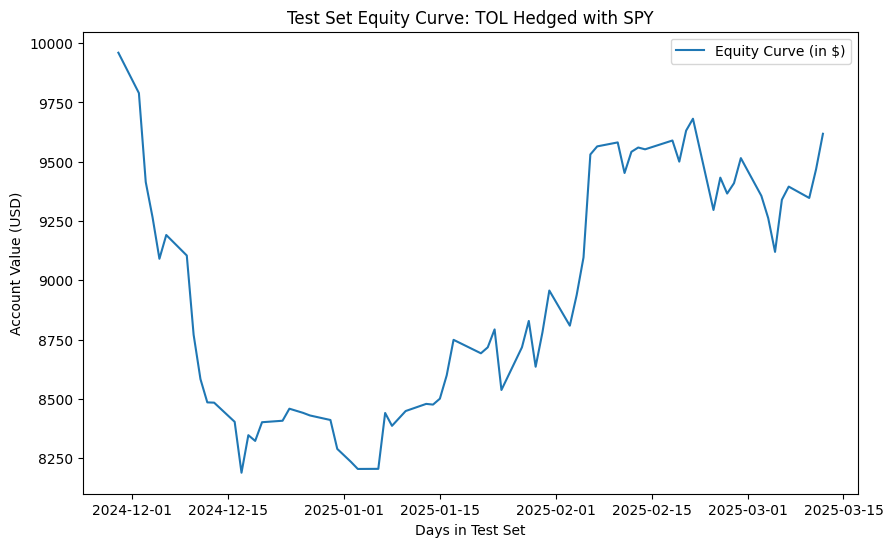

In [ ]:
def dynamic_position_size_z(predicted_excess, mean_pred, std_pred, threshold_z, max_size):

    # Compute the z-score: how many standard deviations the predicted excess is away from the mean.
    z = (predicted_excess - mean_pred) / std_pred
    if abs(z) < threshold_z:
        return 0.0
    # Map the absolute z-score to a position size (here a simple linear mapping)
    pos_size_v2 = abs(z)
    return min(pos_size_v2, max_size)  # Returns the position size as a fraction of capital

# Using model predictions on the training set to calculate mean and std for dynamic sizing
y_train_pred = model.predict(X_train).flatten()
mean_train_pred = np.mean(y_train_pred)
std_train_pred = np.std(y_train_pred)
print(f"Mean prediction for training period: {mean_train_pred}")
print(f"Standard deviation of predictions for training period: {std_train_pred}")

# Now compute dynamic position sizing in the P&L loop on the test set
daily_returns_v2 = []
position_sizes_v2 = []

for i in range(len(df_test_for_pnl)):
    pred = df_test_for_pnl['Predicted_Excess'].iloc[i]
    # threshold z=0.0 means every non-zero prediction results in a trade, adjust if needed
    position_size = dynamic_position_size_z(pred, mean_train_pred, std_train_pred, threshold_z=0.0, max_size=1.0)
    position_sizes_v2.append(position_size)

    if pred > 0:
        # Long stock, short Hedge_1
        dr = position_size * (df_test_for_pnl['Stock_Change_Shifted'].iloc[i] - df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i])
    elif pred < 0:
        # Long Hedge_1, short stock
        dr = position_size * (df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i] - df_test_for_pnl['Stock_Change_Shifted'].iloc[i])
    else:
        dr = 0.0  # No position if prediction is exactly zero.

    if dr != 0:
            dr = dr - transaction_cost  # Only subtract transaction cost if a trade is executed (dr != 0)
    else:
        dr = 0.0  # No trade

    daily_returns_v2.append(dr)

df_test_for_pnl['Position_Size_v2'] = position_sizes_v2
df_test_for_pnl['Daily_Return_%'] = daily_returns_v2


# Performance

calculate_capital_curve(df_test_for_pnl, initial_capital)
calculate_final_pnl(df_test_for_pnl, initial_capital)
calculate_perf(df_test_for_pnl)
calculate_sharpe_ratio(df_test_for_pnl)
plot_curve(df_test_for_pnl, initial_capital)

**Plot Individual Loss for Each Day in Test Set**

Mean Absolute Error (in %): 1.35%


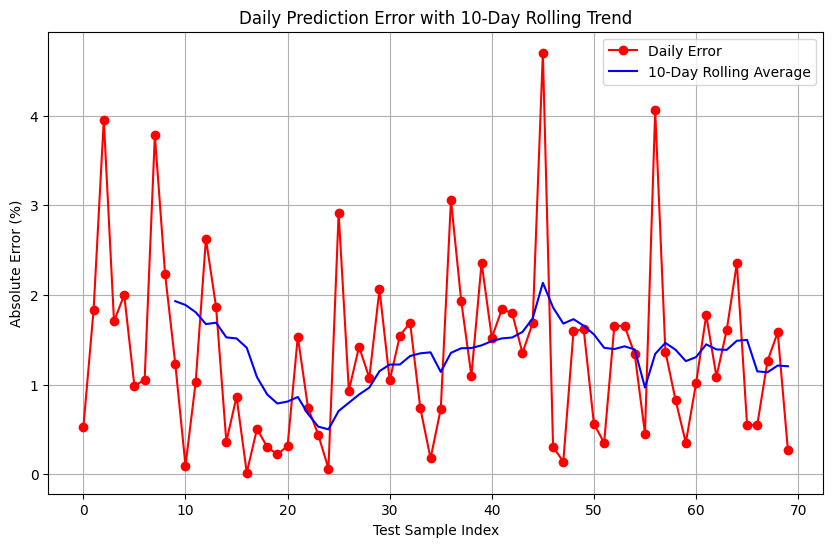

In [ ]:
# Assuming y_pred_unscaled and y_test_unscaled are arrays of predictions and actual values in percentage points.
errors_pct = np.abs(y_pred_unscaled - y_test_unscaled)

# Optionally, compute average error and other statistics:
mean_error = np.mean(errors_pct)
print(f"Mean Absolute Error (in %): {mean_error:.2f}%")

# Generate x-values corresponding to each test sample
x = np.arange(len(errors_pct))

# Compute a 10-day rolling average (moving average) of the errors
rolling_window = 10
rolling_trend = pd.Series(errors_pct).rolling(window=rolling_window).mean()

# Plot the daily errors and the 10-day rolling average as a trend line
plt.figure(figsize=(10,6))
plt.plot(x, errors_pct, marker='o', linestyle='-', color='red', label='Daily Error')
plt.plot(x, rolling_trend, color='blue', label='10-Day Rolling Average')
plt.xlabel('Test Sample Index')
plt.ylabel('Absolute Error (%)')
plt.title('Daily Prediction Error with 10-Day Rolling Trend')
plt.legend()
plt.grid(True)
plt.show()


**Check if Errors Increase Around EPS**

In [ ]:
# Add baseline prediction for comparison
df_test_for_pnl['Historical_Prediction'] = df_test.loc[df_test_for_pnl.index, 'Historical_Prediction']

# Add 'Actual_Excess'
df_test_for_pnl['Actual_Excess'] = y_test_unscaled

# Calculate the absolute error for the baseline predictions.
df_test_for_pnl['Absolute_Error_Baseline'] = np.abs(df_test_for_pnl['Historical_Prediction'] - df_test_for_pnl['Actual_Excess'])

# Add 'Days_Since_EPS'
df_test_for_pnl['Days_Since_EPS'] = stock_data.loc[df_test_for_pnl.index, 'Days_Since_EPS']

# Calculate the absolute error for each prediction
df_test_for_pnl['Absolute_Error'] = np.abs(df_test_for_pnl['Predicted_Excess'] - df_test_for_pnl['Actual_Excess'])

# Group by Days_Since_EPS
group_less_11 = df_test_for_pnl[df_test_for_pnl['Days_Since_EPS'] <= 10]
group_11_to_52 = df_test_for_pnl[(df_test_for_pnl['Days_Since_EPS'] > 10) & (df_test_for_pnl['Days_Since_EPS'] < 53)]
group_53_or_more = df_test_for_pnl[df_test_for_pnl['Days_Since_EPS'] >= 53]

# Compute the mean absolute error (MAE) for the baseline in each group:
mae_less_11_baseline = group_less_11['Absolute_Error_Baseline'].mean()
mae_11_to_52_baseline = group_11_to_52['Absolute_Error_Baseline'].mean()
mae_53_or_more_baseline = group_53_or_more['Absolute_Error_Baseline'].mean()

# Compute the mean absolute error (MAE) for the model each group
mae_less_11_model = group_less_11['Absolute_Error'].mean()
mae_11_to_52_model = group_11_to_52['Absolute_Error'].mean()
mae_53_or_more_model = group_53_or_more['Absolute_Error'].mean()

# Print the comparison
print(f"Days_Since_EPS <= 10:")
print(f"  Baseline MAE: {mae_less_11_baseline:.2f}%  |  Model MAE: {mae_less_11_model:.2f}%")
print(f"Days_Since_EPS 11 to 52:")
print(f"  Baseline MAE: {mae_11_to_52_baseline:.2f}%  |  Model MAE: {mae_11_to_52_model:.2f}%")
print(f"Days_Since_EPS >= 53:")
print(f"  Baseline MAE: {mae_53_or_more_baseline:.2f}%  |  Model MAE: {mae_53_or_more_model:.2f}%")


Days_Since_EPS <= 10:
  Baseline MAE: 1.38%  |  Model MAE: 1.40%
Days_Since_EPS 11 to 52:
  Baseline MAE: 1.27%  |  Model MAE: 1.25%
Days_Since_EPS >= 53:
  Baseline MAE: 1.76%  |  Model MAE: 1.83%


**Split Test Data into Two Halves to Evaluate Model Degradation**

In [ ]:
# Split the test set in half based on index position (if evenly distributed by date)
mid_point = len(df_test_for_pnl) // 2
first_half = df_test_for_pnl.iloc[:mid_point]
second_half = df_test_for_pnl.iloc[mid_point:]

mae_first_half = first_half['Absolute_Error'].mean()
mae_second_half = second_half['Absolute_Error'].mean()

print(f"MAE for the first half: {mae_first_half:.2f}%")
print(f"MAE for the second half: {mae_second_half:.2f}%")

MAE for the first half: 1.25%
MAE for the second half: 1.44%


**Combine EPS Proximity and 1st/2nd Half Performance**

In [ ]:
# Split the test set in half based on index position (if evenly distributed by date)

group_less_11_1st_half = first_half[first_half['Days_Since_EPS'] <= 10]
group_11_to_52_1st_half = first_half[(first_half['Days_Since_EPS'] > 10) & (first_half['Days_Since_EPS'] < 53)]
group_53_or_more_1st_half = first_half[first_half['Days_Since_EPS'] >= 53]

group_less_11_2nd_half = second_half[second_half['Days_Since_EPS'] <= 10]
group_11_to_52_2nd_half = second_half[(second_half['Days_Since_EPS'] > 10) & (second_half['Days_Since_EPS'] < 53)]
group_53_or_more_2nd_half = second_half[second_half['Days_Since_EPS'] >= 53]

# Compute the mean absolute error (MAE) for each group
mae_group_less_11_1st_half = group_less_11_1st_half['Absolute_Error'].mean()
mae_group_11_to_52_1st_half = group_11_to_52_1st_half['Absolute_Error'].mean()
mae_group_53_or_more_1st_half = group_53_or_more_1st_half['Absolute_Error'].mean()

mae_group_less_11_2nd_half = group_less_11_2nd_half['Absolute_Error'].mean()
mae_group_11_to_52_2nd_half = group_11_to_52_2nd_half['Absolute_Error'].mean()
mae_group_53_or_more_2nd_half = group_53_or_more_2nd_half['Absolute_Error'].mean()

# Compute the number of trading days in each group
n_less_11_1st = group_less_11_1st_half.shape[0]
n_11_to_52_1st = group_11_to_52_1st_half.shape[0]
n_53_or_more_1st = group_53_or_more_1st_half.shape[0]

n_less_11_2nd = group_less_11_2nd_half.shape[0]
n_11_to_52_2nd = group_11_to_52_2nd_half.shape[0]
n_53_or_more_2nd = group_53_or_more_2nd_half.shape[0]

# Print
print(f"MAE for the first half, Days_Since_EPS <= 11: {mae_group_less_11_1st_half:.2f}% ({n_less_11_1st} days)")
print(f"MAE for the first half, Days_Since_EPS 11 to 53: {mae_group_11_to_52_1st_half:.2f}% ({n_11_to_52_1st} days)")
print(f"MAE for the first half, Days_Since_EPS >= 53: {mae_group_53_or_more_1st_half:.2f}% ({n_53_or_more_1st} days)")
print()
print(f"MAE for the second half, Days_Since_EPS <= 11: {mae_group_less_11_2nd_half:.2f}% ({n_less_11_2nd} days)")
print(f"MAE for the second half, Days_Since_EPS 11 to 53: {mae_group_11_to_52_2nd_half:.2f}% ({n_11_to_52_2nd} days)")
print(f"MAE for the second half, Days_Since_EPS >= 53: {mae_group_53_or_more_2nd_half:.2f}% ({n_53_or_more_2nd} days)")

MAE for the first half, Days_Since_EPS <= 11: 1.38% (11 days)
MAE for the first half, Days_Since_EPS 11 to 53: 0.99% (18 days)
MAE for the first half, Days_Since_EPS >= 53: 1.83% (6 days)

MAE for the second half, Days_Since_EPS <= 11: 1.42% (11 days)
MAE for the second half, Days_Since_EPS 11 to 53: 1.45% (24 days)
MAE for the second half, Days_Since_EPS >= 53: nan% (0 days)


In [ ]:
pd.set_option('display.max_rows', None)
print(second_half)

               Open      High       Low   Close   Volume  Day of Week   Day_Sin   Day_Cos  Days_Since_EPS  Targ_Stock_Current_Day_%_Change  Targ_Stock_Next_Day_%_Change  Index_1_Daily_%_Change  hedge_1_Daily_%_Change  Excess_Return_vs_Hedge_1  Next_Day_Excess_Return_vs_Hedge_1  Targ_Stock_Daily_Range_%  Index_1_High  Index_1_Low  hedge_1_High  hedge_1_Low  Index_1_Daily_Range_%  hedge_1_Daily_Range_%  Targ_to_Hedge_1_Daily_Range_Ratio  Targ_Stock_ATR  Rolling_Corr_20  Rel_Volume  Volume_MA_10  Volume_MA_50  Scaled_Targ_Stock_Current_Day_%_Change  Scaled_Volume  Scaled_Days_Since_EPS  Scaled_Targ_Stock_Next_Day_%_Change  Scaled_Next_Day_Excess_Return_vs_Hedge_1  Scaled_Index_1_%_Change  Scaled_hedge_1_%_Change  Scaled_Targ_Stock_Daily_Range_%  Scaled_Index_1_Daily_Range_%  Scaled_hedge_1_Daily_Range_%  Targ_to_Hedge_1_Scaled_Daily_Range_Ratio  Scaled_Targ_Stock_ATR  Scaled_Rolling_Corr_20  Scaled_Rel_Volume  Scaled_Volume_MA_10  Scaled_Volume_MA_50  Historical_Prediction  \
2025-01-23  

**Trading Strategy #1 with no trading around earnings**

2024-11-29    10000.000000
2024-12-02    10000.000000
2024-12-03    10000.000000
2024-12-04    10000.000000
2024-12-05    10000.000000
2024-12-06    10000.000000
2024-12-09    10000.000000
2024-12-10    10000.000000
2024-12-11    10000.000000
2024-12-12    10000.000000
2024-12-13    10000.000000
2024-12-16    10000.000000
2024-12-17    10000.000000
2024-12-18    10000.000000
2024-12-19    10000.000000
2024-12-20    10000.000000
2024-12-23    10003.208926
2024-12-24    10032.913573
2024-12-26    10022.004218
2024-12-27    10015.012648
2024-12-30    10003.125260
2024-12-31     9930.171086
2025-01-02     9896.944276
2025-01-03     9878.518373
2025-01-06     9878.289371
2025-01-07    10024.633370
2025-01-08     9979.697010
2025-01-10    10051.964390
2025-01-13    10106.755083
2025-01-14    10002.511878
2025-01-15    10053.947694
2025-01-16    10131.825299
2025-01-17    10219.427426
2025-01-21    10185.758247
2025-01-22    10199.998317
2025-01-23    10243.668933
2025-01-24    10094.447295
2

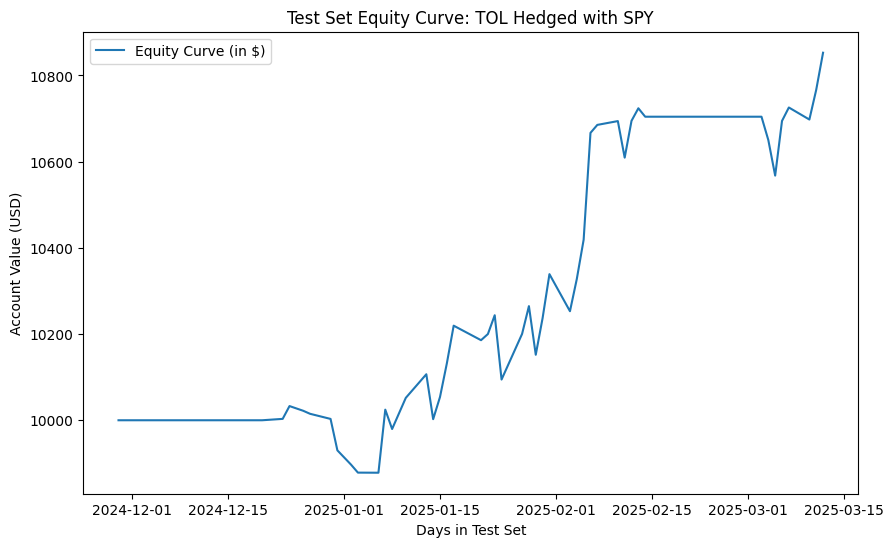

In [ ]:
# Initialize a list to store daily returns for the filtered strategy.
daily_returns_EPS = []

# Loop over each trading day in the test DataFrame.
for i in range(len(df_test_for_pnl)):
    days_since_eps = df_test_for_pnl['Days_Since_EPS'].iloc[i]

    # Check if Days_Since_EPS is between 10 and 53.
    if days_since_eps is not None and 10 <= days_since_eps <= 53:
        pred = df_test_for_pnl['Predicted_Excess'].iloc[i]

        # Calculate the daily return based on the trade direction.
        if pred > 0:
            # Long stock, short SPY.
            dr = 0.5 * (df_test_for_pnl['Stock_Change_Shifted'].iloc[i] - df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i])
        elif pred < 0:
            # Long SPY, short stock.
            dr = 0.5 * (df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i] - df_test_for_pnl['Stock_Change_Shifted'].iloc[i])
        else:
            dr = 0.0

        # Subtract transaction cost only if a trade is executed (dr is nonzero)
        if dr != 0:
            dr = dr - transaction_cost
    else:
        # No trade if Days_Since_EPS is not in the range.
        dr = 0.0

    daily_returns_EPS.append(dr)

df_test_for_pnl['Daily_Return_%'] = daily_returns_EPS

# Performance

calculate_capital_curve(df_test_for_pnl, initial_capital)
calculate_final_pnl(df_test_for_pnl, initial_capital)
calculate_perf(df_test_for_pnl)
calculate_sharpe_ratio(df_test_for_pnl)
plot_curve(df_test_for_pnl, initial_capital)

**Trading Strategy #2 with no earnings around EPS**

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean prediction for training period: 0.017566272988915443
Standard deviation of predictions for training period: 0.05424731969833374
2024-11-29    10000.000000
2024-12-02    10000.000000
2024-12-03    10000.000000
2024-12-04    10000.000000
2024-12-05    10000.000000
2024-12-06    10000.000000
2024-12-09    10000.000000
2024-12-10    10000.000000
2024-12-11    10000.000000
2024-12-12    10000.000000
2024-12-13    10000.000000
2024-12-16    10000.000000
2024-12-17    10000.000000
2024-12-18    10000.000000
2024-12-19    10000.000000
2024-12-20    10000.000000
2024-12-23    10007.417851
2024-12-24    10067.852885
2024-12-26    10046.964978
2024-12-27    10033.951707
2024-12-30    10011.135366
2024-12-31     9866.111295
2025-01-02     9801.072979
2025-01-03     9765.558264
2025-01-06     9766.082051
2025-01-07    10046.402679
2025-01-08     9981.879450
2025-01-10    10056.169532
2025-01-13    10091.973560
2025-01-14    10088.490028
2025-01-15    1011

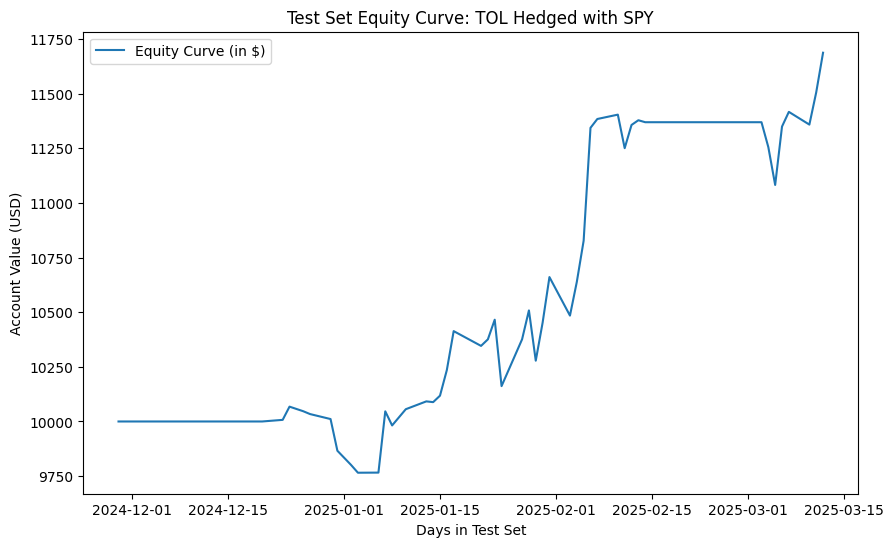

In [ ]:
def dynamic_position_size_z(predicted_excess, mean_pred, std_pred, threshold_z, max_size):

    # Compute the z-score
    z = (predicted_excess - mean_pred) / std_pred
    if abs(z) < threshold_z:
        return 0.0
    # Map the absolute z-score to a position size (here a simple linear mapping)
    pos_size = abs(z)
    return min(pos_size, max_size)

# Using model predictions on the training set to calculate mean and std for dynamic sizing
y_train_pred = model.predict(X_train).flatten()
mean_train_pred = np.mean(y_train_pred)
std_train_pred = np.std(y_train_pred)
print(f"Mean prediction for training period: {mean_train_pred}")
print(f"Standard deviation of predictions for training period: {std_train_pred}")

# Initialize lists for dynamic position sizing (EPS-filtered strategy)
daily_returns_v2_EPS = []
position_sizes_v2_EPS = []

# Loop over the test set (df_test_for_pnl should already have columns:
# 'Predicted_Excess', 'Stock_Change', 'hedge_1_Change', and 'Days_Since_EPS')
for i in range(len(df_test_for_pnl)):
    days_since_eps = df_test_for_pnl['Days_Since_EPS'].iloc[i]

    # Only trade if Days_Since_EPS is between 10 and 53 (inclusive)
    if days_since_eps is not None and 10 <= days_since_eps <= 53:
        pred = df_test_for_pnl['Predicted_Excess'].iloc[i]
        position_size = dynamic_position_size_z(pred, mean_train_pred, std_train_pred, threshold_z=0.0, max_size=1.0)

        if pred > 0:
            # Trade: Long stock, short Hedge_1.
            dr = position_size * (df_test_for_pnl['Stock_Change_Shifted'].iloc[i] - df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i])
        elif pred < 0:
            # Trade: Long Hedge_1, short stock.
            dr = position_size * (df_test_for_pnl['hedge_1_Change_Shifted'].iloc[i] - df_test_for_pnl['Stock_Change_Shifted'].iloc[i])
        else:
            dr = 0.0

        # Subtract transaction cost only if a trade is executed (dr != 0)
        if dr != 0:
            dr = dr - transaction_cost
    else:
        # If Days_Since_EPS is not in the desired range, no trade is placed.
        dr = 0.0
        position_size = 0.0

    daily_returns_v2_EPS.append(dr)
    position_sizes_v2_EPS.append(position_size)

# Store the computed values in the DataFrame
df_test_for_pnl['Position_Size_v2_EPS'] = position_sizes_v2_EPS
df_test_for_pnl['Daily_Return_%'] = daily_returns_v2_EPS

# Performance
calculate_capital_curve(df_test_for_pnl, initial_capital)
calculate_final_pnl(df_test_for_pnl, initial_capital)
calculate_perf(df_test_for_pnl)
calculate_sharpe_ratio(df_test_for_pnl)
plot_curve(df_test_for_pnl, initial_capital)